In [1]:
from problem_constants import *
from tqdm.notebook import tqdm
import pickle

In [2]:
import numpy as np
import pandas as pd

class Timetable():
    def __init__(self, room_assignments=None, datetime_assignments=None):    
        self.room_assignments = room_assignments
        self.datetime_assignments = datetime_assignments
        self.c_r_matrix = self.create_course_room_matrix()
        self.c_d_matrix = self.create_course_datetime_matrix()
        self.s_d_matrix = np.dot(s_c_matrix, self.c_d_matrix)
        self.r_d_matrix = np.dot(self.c_r_matrix.T, self.c_d_matrix)
        self.facility_violations = 0
        self.capacity_violations = 0
        self.overlap_violations = 0
        self.room_violations = 0
        self.soft_penalty = self.calculate_soft_penalty()
        self.hard_penalty = self.facility_violations + self.capacity_violations+ self.overlap_violations + self.room_violations



    
    def is_feasible(self, verbose = False):
        output = True
        assigned_rooms = np.argmax(self.c_r_matrix, axis=1)
        required_facility = c_f_matrix
        available_facility = r_f_matrix[assigned_rooms, :]
        facility_check = required_facility <= available_facility
        
        if not facility_check.all():
            self.facility_violations = np.sum(~facility_check)
            print(verbose*f"Violations in facility check: {self.facility_violations} at {np.where(~facility_check)}\n", end="")
            # Optionally print the specific indices where the condition fails
            #print(np.where(~facility_check))
            output = False

        c_r_student = self.c_r_matrix * numStudent_list[:,np.newaxis]
        student_count_per_room = np.dot(c_r_student.T, self.c_r_matrix)
        capacity_check = student_count_per_room <= capacity_list[:, np.newaxis]
        if not capacity_check.all():
            self.capacity_violations = np.sum(~capacity_check)
            print(verbose*f"Violations in capacity check: {self.capacity_violations} at {np.where(~capacity_check)}\n", end="")
            # Optionally print the specific indices where the condition fails
            # print(np.where(~capacity_check))
            output =  False

        if not np.all(self.s_d_matrix <= 1):
            self.overlap_violations = (np.sum(self.s_d_matrix > 1))/numCourses
            print(verbose*f"Violations in student overlap check: {self.overlap_violations} at {np.where(self.s_d_matrix > 1)}\n", end="")
            # Optionally print the specific indices where the condition fails
            # print(np.where(self.s_d_matrix > 1))
            output = False

        if not (self.r_d_matrix <= 1).all():
            self.room_violations = np.sum(self.r_d_matrix > 1)
            print(verbose*f"Violations in room overlap check: {self.room_violations} at {np.where(self.r_d_matrix > 1)}\n", end="")
            # Optionally print the specific indices where the condition fails
            # print(np.where(self.r_d_matrix > 1))
            output =  False
        return output
    
    def calculate_soft_penalty(self):
        self.is_feasible()
        hard_penalty = self.facility_violations + self.capacity_violations+ self.overlap_violations + self.room_violations
        weight = 1e6
        days_assigned = day[self.datetime_assignments]
        diff_matrix = days_assigned[:, None] - days_assigned
        proximity_matrix = np.where(diff_matrix < 5, np.power(2, np.abs(5 - diff_matrix)), 0)
        penalty = np.sum(np.triu(conflict_matrix * proximity_matrix, 1))
        return penalty #+ weight*hard_penalty

    def create_course_room_matrix(self):
        course_room_matrix = np.zeros((numCourses, numRooms))
        course_room_matrix[np.arange(numCourses), self.room_assignments] = 1
        return course_room_matrix
    
    def create_course_datetime_matrix(self):
        course_datetime_matrix = np.zeros((numCourses, numDatetime))
        course_datetime_matrix[np.arange(numCourses), self.datetime_assignments] = 1
        return course_datetime_matrix
      
    def display(self):
        data = {
            "courses" : course_list,
            "room" : [room_list[room] for room in self.room_assignments],
            "datetime" : [datetime_list[datetime] for datetime in self.datetime_assignments]
            
        }
        return pd.DataFrame(data)











def create_assignments():
    # Initialize room and datetime assignments with -1
    d_a = np.full(numCourses, -1)
    r_a = np.full(numCourses, -1)
    
    # Conflict mask and count of conflicts for each course
    conflict_mask = conflict_matrix.astype(bool)
    conflict_count = conflict_mask.sum(axis=1)
    
    # Sort courses by the number of conflicts in descending order
    sorted_courses = np.argsort(conflict_count)[::-1]
    course_index = 0
    
    while course_index < len(sorted_courses):
        course = sorted_courses[course_index]
        
        # Find feasible rooms for the course
        feasible_rooms = np.where(c_r_feasible[course])[0].tolist()
        
        # If no feasible rooms, move this course to the beginning of the list and restart
        if not feasible_rooms:
            print(f"No feasible rooms for course {course}, restarting...")
            sorted_courses = np.insert(np.delete(sorted_courses, course_index), 0, course)
            course_index = 0
            d_a.fill(-1)
            r_a.fill(-1)
            continue
        
        room_assigned = False
        while feasible_rooms:
            # Randomly select a room from feasible rooms and remove it from the list
            room = np.random.choice(feasible_rooms)
            feasible_rooms.remove(room)
            
            # Determine available datetimes with no conflicts and no exam in the selected room
            available_datetimes = np.array([
                dt for dt in range(numDatetime)
                if all((d_a[other_course] != dt or not conflict_mask[course][other_course])
                       for other_course in range(numCourses) if d_a[other_course] != -1) and
                   all((d_a[other_course] != dt or r_a[other_course] != room)
                       for other_course in range(numCourses) if r_a[other_course] == room)
            ])
            
            # If no available datetimes, try the next room
            if available_datetimes.size == 0:
                #print(f"No available datetime for course {course} in room {room}, trying next room...")
                continue
            
            # Randomly select an available datetime
            datetime = np.random.choice(available_datetimes)
            
            # Assign the room and datetime to the course
            r_a[course] = room
            d_a[course] = datetime
            room_assigned = True
            break
        
        if not room_assigned:
            # If no feasible room is found, put the course at the beginning of the list and restart
            print(f"No feasible datetime found for course {course}, restarting...")
            sorted_courses = np.insert(np.delete(sorted_courses, course_index), 0, course)
            course_index = 0
            d_a.fill(-1)
            r_a.fill(-1)
        else:
            course_index += 1
    
    return r_a, d_a






def calculate_weighted_penalty(timetable, weight=1e6):
    return timetable.soft_penalty + timetable.hard_penalty*weight
    
    
    
def tournament_selection(population, pool_size=50, tournament_size=3):
    # Convert population to a numpy array for easier manipulation
    population_array = np.array(population)
    
    selected = []
    
    for _ in range(pool_size):
        tournament_indices = np.random.choice(len(population), size=tournament_size, replace=False)
        tournament = population_array[tournament_indices]
        winner = np.argmin([calculate_weighted_penalty(timetable) for timetable in tournament])
        
        # Append the selected timetable to the list
        selected.append(tournament[winner])
    
    
    return selected
    
    
    


def crossover(self, other):
    ra_1 = self.room_assignments
    ra_2 = other.room_assignments
    da_1 = self.datetime_assignments
    da_2 = other.datetime_assignments

    r_crossover = np.random.randint(1, numCourses)
    ra_3 = np.concatenate((ra_1[:r_crossover], ra_2[r_crossover:]))
    ra_4 = np.concatenate((ra_2[:r_crossover], ra_1[r_crossover:]))

    d_crossover = np.random.randint(1, numCourses)
    da_3 = np.concatenate((da_1[:d_crossover], da_2[d_crossover:]))
    da_4 = np.concatenate((da_2[:d_crossover], da_1[d_crossover:]))

    return Timetable(ra_3, da_3), Timetable(ra_4, da_4)

def mutate(self, mutation_rate=0.3):
    #room
    mutated_room = self.room_assignments.copy()
    random_numbers = np.random.rand(numCourses)
    mutate_mask = random_numbers < mutation_rate
    mutated_room[mutate_mask] = np.random.randint(numRooms, size = mutate_mask.sum())
    #datetime
    mutated_datetime = self.datetime_assignments.copy()
    random_numbers = np.random.rand(numCourses)
    mutate_mask = random_numbers < mutation_rate
    mutated_datetime[mutate_mask] = np.random.randint(numDatetime, size = mutate_mask.sum())

    return Timetable(mutated_room, mutated_datetime)



In [3]:
population = []
new = np.empty((0,1))
for i in tqdm(range(100), desc="Creating population", unit="timetables"):
    while True:
        r_a, d_a = create_assignments()
        if r_a is not None:
            timetable = Timetable(r_a, d_a)
            population.append(timetable)
            curr = np.array([calculate_weighted_penalty(timetable)])
            new = np.vstack([new, curr])
            break

penalty_list = sorted([calculate_weighted_penalty(x) for x in population])
print(f"Best : {penalty_list[0]:,} , Worst : {penalty_list[-1]:,}")

Creating population:   0%|          | 0/100 [00:00<?, ?timetables/s]

No feasible datetime found for course 39, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 22, restar

No feasible datetime found for course 50, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 45, restar

No feasible datetime found for course 3, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 36, restart

No feasible datetime found for course 15, restarting...
No feasible datetime found for course 78, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 47, restar

No feasible datetime found for course 69, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 43, restar

No feasible datetime found for course 55, restarting...
No feasible datetime found for course 12, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 10, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 68, restar

No feasible datetime found for course 43, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 57, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 14, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 46, restar

No feasible datetime found for course 53, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 29, restar

No feasible datetime found for course 70, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 38, restar

No feasible datetime found for course 43, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 56, restar

No feasible datetime found for course 67, restarting...
No feasible datetime found for course 16, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 72, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 45, restar

No feasible datetime found for course 68, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 45, restar

No feasible datetime found for course 67, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 37, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 78, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 24, restar

No feasible datetime found for course 29, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 53, restar

No feasible datetime found for course 35, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 28, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 16, restar

No feasible datetime found for course 67, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 56, restar

No feasible datetime found for course 18, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 44, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 47, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 28, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 70, restar

No feasible datetime found for course 55, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 16, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 23, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 52, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 48, restar

No feasible datetime found for course 49, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 58, restarting...
No feasible datetime found for course 53, restar

No feasible datetime found for course 21, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 28, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 57, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 16, restar

No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 14, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 45, restar

No feasible datetime found for course 21, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 72, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 16, restarting...
No feasible datetime found for course 36, restar

No feasible datetime found for course 18, restarting...
No feasible datetime found for course 28, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 58, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 25, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 67, restar

No feasible datetime found for course 21, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 50, restar

No feasible datetime found for course 45, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 57, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 7, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 25, restart

No feasible datetime found for course 49, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 52, restar

No feasible datetime found for course 25, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 14, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 28, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 69, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 78, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 56, restar

No feasible datetime found for course 36, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 57, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 65, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 62, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 24, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 56, restarting...
No feasible datetime found for course 51, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 27, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 67, restar

No feasible datetime found for course 45, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 57, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 16, restar

No feasible datetime found for course 53, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 3, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 68, restart

No feasible datetime found for course 24, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 49, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 57, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 62, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 68, restar

No feasible datetime found for course 30, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 10, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 56, restar

No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 3, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 78, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 36, restart

No feasible datetime found for course 67, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 52, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 62, restarting...
No feasible datetime found for course 54, restar

No feasible datetime found for course 39, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 48, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 56, restar

No feasible datetime found for course 67, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 69, restar

No feasible datetime found for course 46, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 45, restar

No feasible datetime found for course 25, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 16, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 26, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 36, restar

No feasible datetime found for course 67, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 40, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 54, restar

No feasible datetime found for course 43, restarting...
No feasible datetime found for course 78, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 15, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 29, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 19, restarting...
No feasible datetime found for course 58, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 20, restarting...
No feasible datetime found for course 24, restarting...
No feasible datetime found for course 53, restar

No feasible datetime found for course 54, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 78, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 57, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 70, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 12, restar

No feasible datetime found for course 54, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 25, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 21, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 7, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 20, restart

No feasible datetime found for course 56, restarting...
No feasible datetime found for course 55, restarting...
No feasible datetime found for course 43, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 39, restarting...
No feasible datetime found for course 33, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 35, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 30, restarting...
No feasible datetime found for course 31, restarting...
No feasible datetime found for course 13, restarting...
No feasible datetime found for course 32, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 23, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 54, restar

No feasible datetime found for course 43, restarting...
No feasible datetime found for course 34, restarting...
No feasible datetime found for course 53, restarting...
No feasible datetime found for course 45, restarting...
No feasible datetime found for course 68, restarting...
No feasible datetime found for course 69, restarting...
No feasible datetime found for course 18, restarting...
No feasible datetime found for course 56, restarting...
No feasible datetime found for course 22, restarting...
No feasible datetime found for course 46, restarting...
No feasible datetime found for course 38, restarting...
No feasible datetime found for course 67, restarting...
No feasible datetime found for course 36, restarting...
No feasible datetime found for course 37, restarting...
No feasible datetime found for course 49, restarting...
No feasible datetime found for course 50, restarting...
No feasible datetime found for course 54, restarting...
No feasible datetime found for course 55, restar

In [16]:
data = np.empty((0,5))

In [17]:
maxGeneration = 100
popSize = 150


for generation in tqdm(range(maxGeneration + 1), desc="Generations", unit="generation", total=maxGeneration):
    mating_pool_size = 50
    mating_pool = tournament_selection(population, mating_pool_size, 3)
    
    offspring = []
    for i in range(0, mating_pool_size-1, 2):
        parent1 = mating_pool[i]
        parent2 = mating_pool[i+1 % mating_pool_size]
        child1, child2 = crossover(parent1, parent2)
        offspring.append(child1)
        offspring.append(child2)
        
    for idx, child in enumerate(offspring):
        offspring[idx] = mutate(child)
        
    combined_population = population + offspring
    combined_population = sorted(combined_population, key=lambda solution: calculate_weighted_penalty(solution))
    population = list(combined_population[:popSize] if len(combined_population) > popSize else combined_population)
    #=======================================================
    timetable = combined_population[0]
    curr = np.array([timetable.soft_penalty,
                     timetable.facility_violations*1e6,
                     timetable.capacity_violations*1e6,
                     timetable.overlap_violations*1e6,
                     timetable.room_violations*1e6 ])
    data = np.vstack([data, curr])
    #=====================================================
    if generation%(maxGeneration/10) == 0:
        print(f"Generation {generation}: Best = {calculate_weighted_penalty(population[0]):,}, Worst = {calculate_weighted_penalty(population[-1]):,}")
        




Generations:   0%|          | 0/100 [00:00<?, ?generation/s]

Generation 0: Best = 9,210,817,635.851852, Worst = 257,674,641,622.0
Generation 10: Best = 1,951,956,216.9876542, Worst = 14,049,766,128.098766
Generation 20: Best = 1,054,374,624.2962964, Worst = 7,815,401,475.08642
Generation 30: Best = 1,054,374,624.2962964, Worst = 4,972,790,640.444445
Generation 40: Best = 751,428,515.5555556, Worst = 3,843,175,320.567901
Generation 50: Best = 640,736,765.9506173, Worst = 2,992,171,512.617284
Generation 60: Best = 640,736,765.9506173, Worst = 2,513,882,059.4814816
Generation 70: Best = 640,736,765.9506173, Worst = 2,176,747,478.839506
Generation 80: Best = 640,736,765.9506173, Worst = 1,995,832,123.0370371
Generation 90: Best = 424,723,218.2962963, Worst = 1,836,001,730.1975307
Generation 100: Best = 424,723,218.2962963, Worst = 1,705,541,957.308642


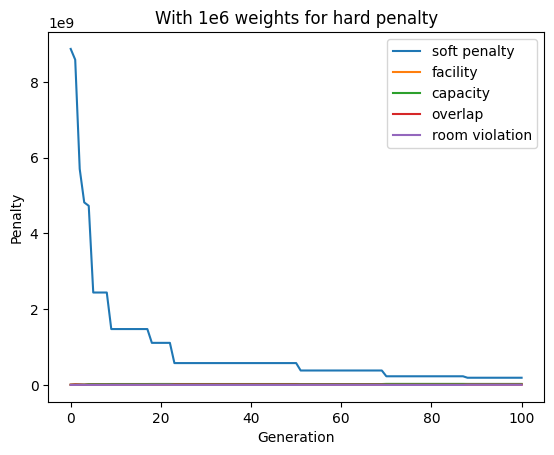

In [13]:
import matplotlib.pyplot as plt
column_name = ['soft penalty', 'facility', 'capacity', 'overlap', 'room violation']
# Number of columns in the array
num_columns = data.shape[1]

# Create a line graph for each column
for i in [0,1,2,3,4]:
    plt.plot(data[:, i], label=column_name[i])

# Add title and labels
plt.title('With 1e6 weights for hard penalty')
plt.xlabel('Generation')
plt.ylabel('Penalty')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
file_name = 'timetables.pkl'
with open(file_name, 'wb') as file:
    pickle.dump({'population': population, 'data': data}, file)

In [ ]:
facility_list